# Cell state dynamics of skin squamous cell carcinoma dependent on colocalized cell population
Exdyn can estimate cell state dynamics dependent on multivariate extrinsic factors such as colocalization with neighboring cells and chromatin accessibility. Exdyn provide several downstream analysis for exploring the contributing fetures of the extrinsic factors. Here, we estimate cell state dynamics of human skin squamous cell carcinoma dependen on the colocalization scores with cells other than cancer cells, which were estimated by DeepCOLOR (). 

## Model setup and optimization
Exdyn accepts AnnData object for dynamics estimation. The model parameters such as the number of neural network layers can be specified through a dictionary of the parameters.

In [1]:
import scanpy as sc
# from exdyn import workflow, modules
from src import workflow, modules, visualization
import numpy as np
import torch
import random
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


adata_file_path = 'data/scc/tumor_adata.h5ad'
coloc_adata_file_path = 'data/scc/coloc_adata.h5ad'
lt_df_file_path = 'data/scc/lt_df.csv'
adata = sc.read_h5ad(adata_file_path)
top_corr_genes, gene_names = workflow.extract_top_corr_genes(adata)
adata.var['dynamics_genes'] = False
adata.var['dynamics_genes'][top_corr_genes] = True

model_params = {
            'x_dim': 100,
            'z_dim': 10,
            'enc_z_h_dim': 128, 'enc_d_h_dim': 128, 'dec_z_h_dim': 128,
            'num_enc_z_layers': 2, 'num_enc_d_layers': 2,
            'num_dec_z_layers': 2, 'use_vamp': False, 'loss_mode': 'nb'
}
checkpoint_dirname = 'checkpoint'
adata.obs['sample'] = 'Sample'
est_adata, model = workflow.conduct_cvicdyf_inference(adata, model_params, checkpoint_dirname, batch_size=128, two_step=False, dyn_mode=False, epoch=1000, patience=50, module=modules.Cvicdyf, use_highly_variable=False, batch_key='sample', condition_key='coloc', cond_in_obsm=True)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/home/tiisaishima/mambaforge/envs/functorch2/lib/python3.10/site-packages/pytorch_lightning/callbacks/progress/progress.py:23: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type         | Params
---------------------------------------------------
0 | enc_z             | EncoderBatch | 1.6 M 
1 | enc_d             | Encoder      | 172 K 
2 | enc_l             | Encoder      | 1.6 M 
3 | enc_ul            | Encoder      | 1.6 M 
4 | dec_z             | DecoderBatch | 1.6 M 
5 | softplus          | Softplus     | 0     
6 | softplus_kinetics | Softplus     | 0     
7 | softmax           | Softmax      | 0     
8 | sigmoid           | Sigmoid      | 0    

Epoch 163: 100%|██████████| 9/9 [03:05<00:00, 20.65s/it, loss=8.23e+03, v_num=5]


## Visualize purturbation of cell state dynamics by extrinsic factors
Exdyn can estimate the purturbation effect on cell state dynamics by extrinsic factors through singular value decompotion of Jacobian matrix.
Firstly, you can visualize the cell state dynamics given original extrinsic factors.

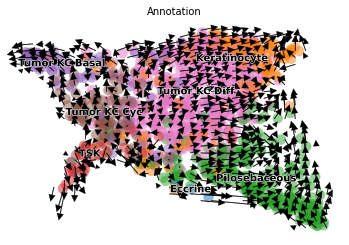

In [4]:
from src import visualization
est_adata.obs['Annotation'] = est_adata.obs['level3_celltype']
visualization.plot_mean_flow(est_adata, cluster_key='Annotation', legend_loc='on data')

Next, you can conduct SVD of Jacobian matrix and identify the pricipal purtubations and the effects on cell state dynamics. Here, you can visualize the purtubed dynamics for top 3 modes.

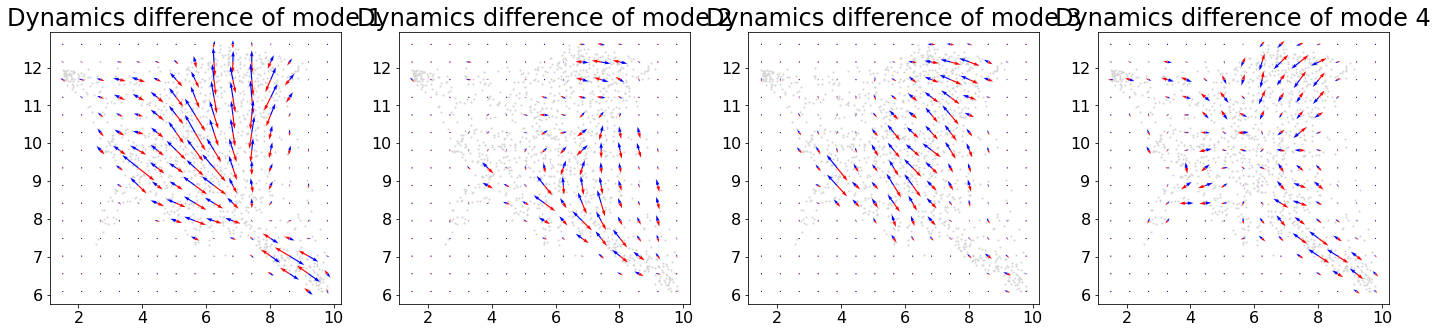

In [6]:
top_modes = 4
est_adata = workflow.conduct_jacobian_analysis(est_adata, model, top_modes=top_modes)
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, top_modes, figsize=(6 * top_modes, 5 * 1))
for mode in range(top_modes):
   ax = axes[mode] 
   visualization.diff_visualize(est_adata.obsm[f'dd_dc_embed{mode}'], est_adata.obsm['X_umap'], ax)
   ax.set_title(f"Dynamics difference of mode {mode + 1}")

fig.show()

We note that the contribution of each feature of extrinsic factors to each mode of principal purturbation can be found in `adata.uns['dd_dc_v']`. This can be useful for identify the fetures which can cause specific cell state transitions.

In [7]:
est_adata.uns['dd_dc_v']

array([[ 0.04910101, -0.02046108,  0.0260555 ,  0.03450557],
       [ 0.00440817,  0.0086675 , -0.01788318, -0.0361691 ],
       [-0.02709828,  0.01477345, -0.00099048,  0.02788326],
       ...,
       [ 0.01542668, -0.037942  ,  0.03695782,  0.02008842],
       [ 0.01559424, -0.06414441, -0.01993151, -0.00457051],
       [-0.02682135,  0.0015646 ,  0.05201469, -0.01512694]],
      dtype=float32)

You can also quantify the induction of each cell cluster by each purturbation.

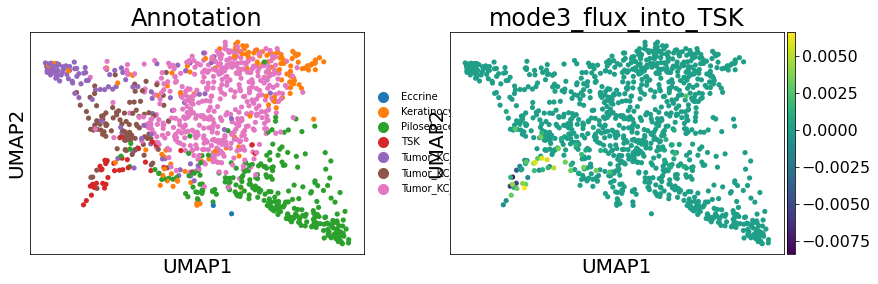

In [8]:
mode = 3
sign = 1
cluster = 'TSK'
est_adata = workflow.analyze_flux_into_clusters(est_adata, cluster, mode, sign, 'Annotation')
sc.pl.umap(est_adata, color=['Annotation', f'mode{mode * sign}_flux_into_{cluster}'])

## Analyze cell cell interacraction
In the case where the extrinsic factors are colozalizaiton scores with neighboring cells, you can analyze cell cell interaction which mediate specific mode of principal purturbation patterns of cell state dynamics. Firstly, you can annotate and visualize the contribution of neighboring cells to each mode of the purturbations.

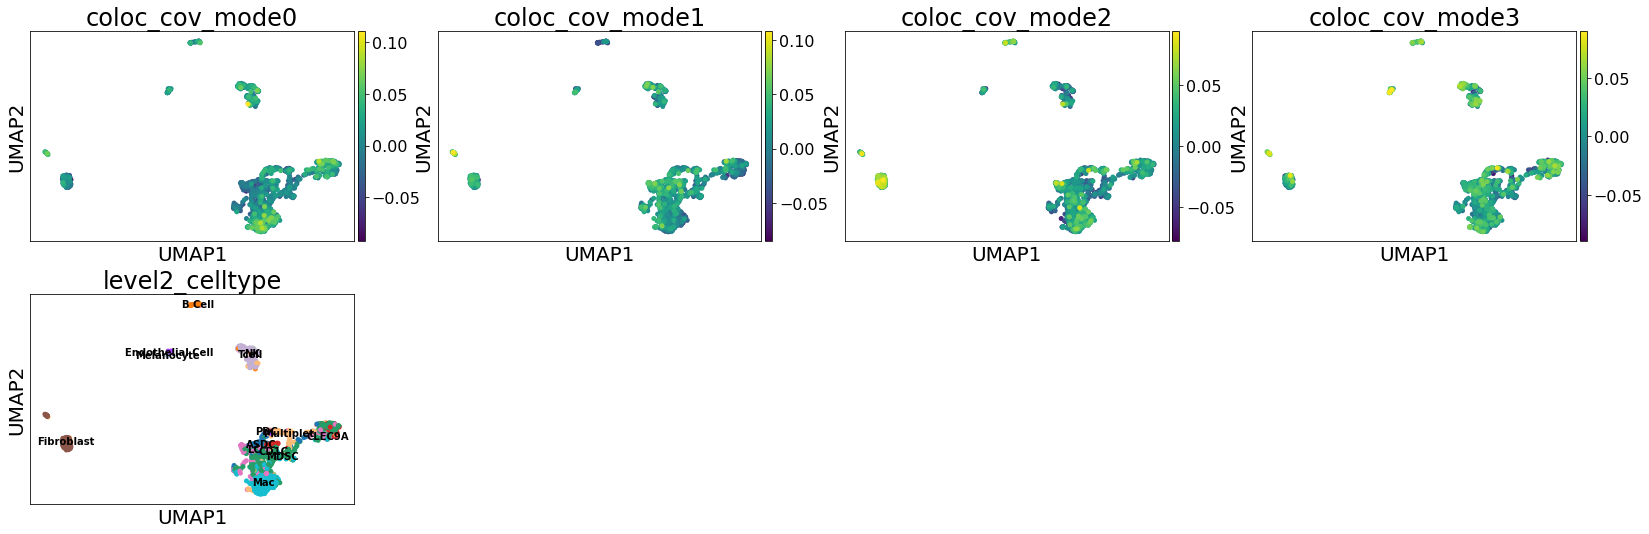

In [10]:
coloc_adata = sc.read_h5ad(coloc_adata_file_path)
cov_labels = []
for i in range(top_modes):
    cov_label = f'coloc_cov_mode{i}'
    coloc_adata.obs[cov_label] = est_adata.uns['dd_dc_v'][:, i]
    cov_labels.append(cov_label)

sc.pl.umap(coloc_adata, color=cov_labels + ['level2_celltype'], legend_loc='on data')

Here, we extract cancer cells directed TSK by mode 1 perturbation and quantify the activity of each ligand for the perturbation.

In [11]:
import pandas as pd
import numpy as np
top_tsk_adata = est_adata[est_adata.obs[f'mode{mode * sign}_flux_into_{cluster}'] > np.quantile(est_adata.obs[f'mode{mode * sign}_flux_into_{cluster}'], 0.95)]
top_tsk_adata = workflow.calc_covdiff(top_tsk_adata, model, mode, sign, 'coloc', 'sample', sep_num=5)
condiff_vec = pd.Series(top_tsk_adata.layers[f'cov_diff_{sign * mode}'].mean(axis=0), top_tsk_adata.var_names)
lt_df = pd.read_csv(lt_df_file_path, index_col=0)
ligacs = workflow.analyze_ligand_activity(condiff_vec, lt_df)


In order to derive plausible candidates for cell cell interaction, you can intersects genes with high ligand activity with positive DEGs for contributing neighboring cells.

In [12]:
coloc_adata.obs['target_coloc'] = (coloc_adata.obs['coloc_cov_mode1'] > np.quantile(coloc_adata.obs['coloc_cov_mode1'], 0.9)).astype(str)
sc.tl.rank_genes_groups(coloc_adata, 'target_coloc', groups=['True'], reference='False', method='wilcoxon')
deg_df = sc.get.rank_genes_groups_df(coloc_adata, 'True')
pos_degs = deg_df.query('pvals_adj < 0.05 and logfoldchanges > 1').names

ligacs[np.intersect1d(pos_degs, ligacs.index)].sort_values(ascending=False)


LUM       0.190784
CALM2     0.183941
CD59      0.144945
COL6A2    0.123433
IGFBP4    0.108469
HMGB1     0.096114
LDHA      0.092607
dtype: float64